#Proof of concept

We are trying to prove if a certain model can learn seasonality pattern

In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow

In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## In this proof of concept we will assume our data has patterns that can be extracted. Instead of using real data, we will use a simple sine function to simulate seasonality and determine if/which models can successfully learn this pattern.

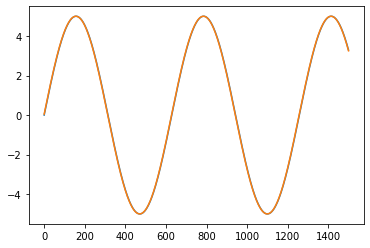

In [ ]:
x_timesteps = np.array([*range(1500)])

def sine_func(val):
  return 5 * math.sin(val/100)

def sine_func2(val):
  return 10 * math.sin(val/1000)

def generate_labels(samples):
  labels=[]
  for i in samples:
    labels.append(sine_func(i))
  return np.array(labels)

x_train = generate_labels(x_timesteps)
y_train = generate_labels(x_timesteps + 1)

plt.plot([*range(len(x_train))], x_train)
plt.plot([*range(len(y_train))], y_train)
plt.show()

x_test_timesteps = np.array([*range(1500, 3000)])
x_test = generate_labels(x_test_timesteps)
y_test = generate_labels(x_test_timesteps + 1)

In [ ]:
print(f"{x_train.shape} {y_train.shape} {x_test.shape} {y_test.shape}")

(1500,) (1500,) (1500,) (1500,)


In [ ]:
def norm(data, scalar = MinMaxScaler()):
    normalized = scalar.fit_transform(data.reshape(-1, 1))
    # normalized = scalar.fit_transform(data)
    # print("Normalized series: ")
    # print(normalized[0])
    return normalized, scalar

def denormalize(scalar, normalized):
    return scalar.inverse_transform(normalized)

In [ ]:
x_train, scalar = norm(x_train)
y_train, scalar = norm(y_train)

x_test, scalar = norm(x_test)
y_test, scalar = norm(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print(f"{x_train.shape} {y_train.shape} {x_test.shape} {y_test.shape}")

(1500, 1) (1500, 1) (1500, 1) (1500, 1)


In [ ]:
# split a univariate sequence into samples
def split_sequence(samples, labels, n_steps):
  X, y = [], []
  for i in range(len(samples)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(samples)-1:
      break
    # gather input and output parts of the pattern
    # print(f"{end_ix} samples shape {samples.shape} labels shape {len(labels)}")
    seq_x, seq_y = samples[i:end_ix], labels[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  
  # Create batches
  X = np.array(X).reshape(len(X), n_steps, 1)
  return X, np.array(y)

In [ ]:
x_train, y_train = split_sequence(x_train, y_train, 200)
x_test, y_test = split_sequence(x_test, y_test, 200)

In [ ]:
print(x_train.shape)

(1300, 200, 1)


## Let's determine which model is better at extracting a singular pattern such as seasonality.

In [ ]:
def plain_lstm_model(n_steps_in, n_features, n_labels):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, input_shape=(n_steps_in, n_features), return_sequences=False))
    model.add(tf.keras.layers.Dense(40,  activation='relu'))
    model.add(tf.keras.layers.Dense(n_labels))
    model.compile(optimizer='adam', loss='mse')
    return model

def bi_lstm_model(n_steps_in, n_features, n_labels):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, input_shape=(n_steps_in, n_features))))
    # model.add(tf.keras.layers.LSTM(10))
    model.add(tf.keras.layers.Dense(n_labels))
    model.compile(optimizer='adam', loss='mse')
    return model

  
def cnn2d_lstm_model(n_steps, n_features, n_labels, n_seq=1):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1, 2), input_shape=(n_seq, 1, n_steps, n_features)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_labels))
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        mode='min',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-5,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        restore_best_weights=True,
        verbose=1)
]

In [ ]:
bi_model = bi_lstm_model(x_train.shape[-2], x_train.shape[-1], 1)
bi_model.fit(x_train, y_train, epochs=5000, validation_data=(x_test, y_test), batch_size=len(x_train), callbacks=callbacks, verbose=2)

Epoch 1/5000
1/1 - 1s - loss: 0.4836 - val_loss: 0.4247
Epoch 2/5000
1/1 - 0s - loss: 0.4554 - val_loss: 0.3999
Epoch 3/5000
1/1 - 0s - loss: 0.4285 - val_loss: 0.3763
Epoch 4/5000
1/1 - 0s - loss: 0.4028 - val_loss: 0.3539
Epoch 5/5000
1/1 - 0s - loss: 0.3783 - val_loss: 0.3325
Epoch 6/5000
1/1 - 0s - loss: 0.3550 - val_loss: 0.3122
Epoch 7/5000
1/1 - 0s - loss: 0.3327 - val_loss: 0.2930
Epoch 8/5000
1/1 - 0s - loss: 0.3115 - val_loss: 0.2747
Epoch 9/5000
1/1 - 0s - loss: 0.2913 - val_loss: 0.2574
Epoch 10/5000
1/1 - 0s - loss: 0.2721 - val_loss: 0.2411
Epoch 11/5000
1/1 - 0s - loss: 0.2539 - val_loss: 0.2258
Epoch 12/5000
1/1 - 0s - loss: 0.2367 - val_loss: 0.2115
Epoch 13/5000
1/1 - 0s - loss: 0.2206 - val_loss: 0.1981
Epoch 14/5000
1/1 - 0s - loss: 0.2055 - val_loss: 0.1858
Epoch 15/5000
1/1 - 0s - loss: 0.1914 - val_loss: 0.1745
Epoch 16/5000
1/1 - 0s - loss: 0.1784 - val_loss: 0.1642
Epoch 17/5000
1/1 - 0s - loss: 0.1664 - val_loss: 0.1549
Epoch 18/5000
1/1 - 0s - loss: 0.1555 - 

In [ ]:
lstm_model = plain_lstm_model(x_train.shape[-2], x_train.shape[-1], 1)
lstm_model.fit(x_train, y_train, epochs=5000, validation_data=(x_test, y_test), batch_size=len(x_train), callbacks=callbacks, verbose=2)

Epoch 1/5000
1/1 - 1s - loss: 0.4611 - val_loss: 0.3837
Epoch 2/5000
1/1 - 0s - loss: 0.4121 - val_loss: 0.3425
Epoch 3/5000
1/1 - 0s - loss: 0.3678 - val_loss: 0.3053
Epoch 4/5000
1/1 - 0s - loss: 0.3279 - val_loss: 0.2772
Epoch 5/5000
1/1 - 0s - loss: 0.2977 - val_loss: 0.2535
Epoch 6/5000
1/1 - 0s - loss: 0.2723 - val_loss: 0.2316
Epoch 7/5000
1/1 - 0s - loss: 0.2488 - val_loss: 0.2108
Epoch 8/5000
1/1 - 0s - loss: 0.2265 - val_loss: 0.1913
Epoch 9/5000
1/1 - 0s - loss: 0.2055 - val_loss: 0.1742
Epoch 10/5000
1/1 - 0s - loss: 0.1872 - val_loss: 0.1571
Epoch 11/5000
1/1 - 0s - loss: 0.1688 - val_loss: 0.1393
Epoch 12/5000
1/1 - 0s - loss: 0.1496 - val_loss: 0.1209
Epoch 13/5000
1/1 - 0s - loss: 0.1298 - val_loss: 0.1022
Epoch 14/5000
1/1 - 0s - loss: 0.1097 - val_loss: 0.0835
Epoch 15/5000
1/1 - 0s - loss: 0.0895 - val_loss: 0.0652
Epoch 16/5000
1/1 - 0s - loss: 0.0698 - val_loss: 0.0481
Epoch 17/5000
1/1 - 0s - loss: 0.0512 - val_loss: 0.0329
Epoch 18/5000
1/1 - 0s - loss: 0.0347 - 

In [ ]:
cnn_model = cnn2d_lstm_model(x_train.shape[-2], x_train.shape[-1], 1)
cnn_model.fit(x_train, y_train, epochs=5000, validation_data=(x_test, y_test), batch_size=len(x_train), callbacks=callbacks, verbose=2)

In [ ]:
def gen_forecast(model, input_data):
  length = len(input_data)
  forecast = input_data.copy()
  forecast = forecast.reshape(1, forecast.shape[-2], forecast.shape[-1])
  for i in range(length):
    predict = model.predict(forecast)
    result = np.append(forecast[0, -(length -1):], predict[0])
    forecast[0] = result.reshape(result.shape[-1], 1)
  return forecast[0]

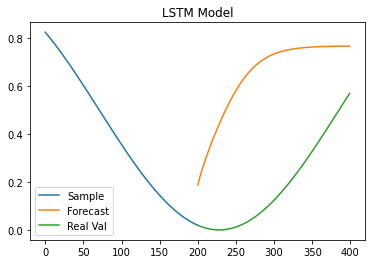

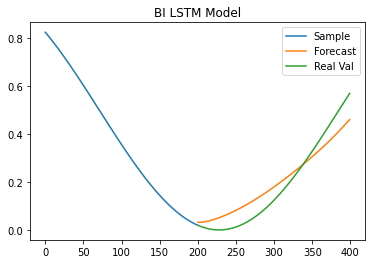

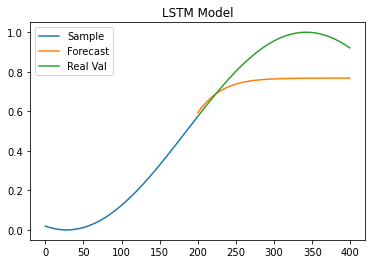

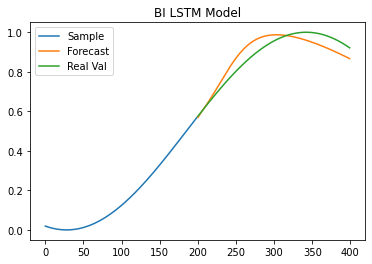

In [ ]:
def plot(history, real_vals, prediction, title):
    length = len(history)
    time_steps = [*range(length)]
    time_steps2 = [*range(length, length*2)]

    plt.title(title)
    plt.plot(time_steps, history, label="Sample")
    plt.plot(time_steps2, prediction, label="Forecast")
    plt.plot(time_steps2, real_vals, label="Real Val")
    plt.legend()
    plt.show()

n_time_steps = len(x_test[0])
for i in range(0, 400, 200):
  history = x_test[i]
  real_vals = x_test[i+(n_time_steps)]
  y_hat = gen_forecast(lstm_model, x_test[i])
  plot(history, real_vals, y_hat, 'LSTM Model')
  y_hat = gen_forecast(bi_model, x_test[i])
  plot(history, real_vals, y_hat, 'BI LSTM Model')
  # y_hat = gen_forecast(cnn_model, x_test[i])
  # plot(history, real_vals, y_hat, 'CNN Model')


### The bidirectional model seems to perform better at extracting seasonality than the plain lstm model.

# Now that we prove we can predict seasonality let's see if these models can extract multiple patterns. let's try to predict seasonality + trend.


In [ ]:
def trend_func(x):
  return x/100

def generate_st_labels(samples):
  labels=[]
  for i in samples:
    labels.append(sine_func(i) + trend_func(i))
  return np.array(labels)

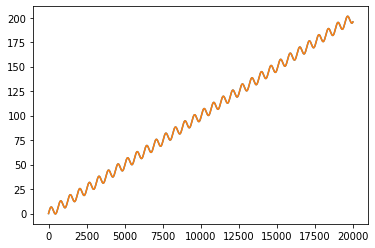

(20000, 1)
(20000, 1)


In [ ]:
x_timesteps = np.array([*range(20000)])
x_test_timesteps = np.array([*range(20000, 30000)])

x_st_train = generate_st_labels(x_timesteps)
y_st_train = generate_st_labels(x_timesteps +1)

x_st_test = generate_st_labels(x_test_timesteps) 
y_st_test = generate_st_labels(x_test_timesteps + 1) 

plt.plot([*range(len(x_st_train))], x_st_train)
plt.plot([*range(len(y_st_train))], y_st_train)
plt.show()

x_st_train, scalar_st = norm(x_st_train)
y_st_train = scalar_st.transform(np.array(y_st_train).reshape(-1, 1))

print(x_st_train.shape)
print(y_st_train.shape)

x_st_test = scalar_st.transform(np.array(x_st_test).reshape(-1, 1))
y_st_test = scalar_st.transform(np.array(y_st_test).reshape(-1, 1))


### This is a graph of simulated seasonality + trend. Our data now is non-stationary. Let's see how our models perform on non-stationary data.

In [ ]:
x_st_train, y_st_train = split_sequence(x_st_train, y_st_train, 500)
x_st_test, y_st_test = split_sequence(x_st_test, y_st_test, 500)

In [ ]:
st_bi_lstm_model = bi_lstm_model(x_st_train.shape[-2], x_st_train.shape[-1], 1)

st_bi_lstm_model.fit(x_st_train, y_st_train, epochs=1000, validation_data=(x_st_test, y_st_test), batch_size=len(x_st_train), callbacks=callbacks, verbose=2)

Epoch 1/1000
1/1 - 4s - loss: 0.2274 - val_loss: 0.9793
Epoch 2/1000
1/1 - 2s - loss: 0.1991 - val_loss: 0.8783
Epoch 3/1000
1/1 - 2s - loss: 0.1725 - val_loss: 0.7822
Epoch 4/1000
1/1 - 2s - loss: 0.1478 - val_loss: 0.6913
Epoch 5/1000
1/1 - 2s - loss: 0.1249 - val_loss: 0.6058
Epoch 6/1000
1/1 - 2s - loss: 0.1039 - val_loss: 0.5257
Epoch 7/1000
1/1 - 2s - loss: 0.0848 - val_loss: 0.4511
Epoch 8/1000
1/1 - 2s - loss: 0.0677 - val_loss: 0.3823
Epoch 9/1000
1/1 - 2s - loss: 0.0526 - val_loss: 0.3193
Epoch 10/1000
1/1 - 2s - loss: 0.0396 - val_loss: 0.2623
Epoch 11/1000
1/1 - 2s - loss: 0.0286 - val_loss: 0.2113
Epoch 12/1000
1/1 - 2s - loss: 0.0198 - val_loss: 0.1666
Epoch 13/1000
1/1 - 2s - loss: 0.0132 - val_loss: 0.1281
Epoch 14/1000
1/1 - 2s - loss: 0.0087 - val_loss: 0.0960
Epoch 15/1000
1/1 - 2s - loss: 0.0063 - val_loss: 0.0700
Epoch 16/1000
1/1 - 2s - loss: 0.0058 - val_loss: 0.0499
Epoch 17/1000
1/1 - 2s - loss: 0.0068 - val_loss: 0.0352
Epoch 18/1000
1/1 - 2s - loss: 0.0089 - 

In [ ]:
st_lstm_model = plain_lstm_model(x_st_train.shape[-2], x_st_train.shape[-1], 1)

st_lstm_model.fit(x_st_train, y_st_train, epochs=1000, validation_data=(x_st_test, y_st_test), batch_size=len(x_st_train), callbacks=callbacks, verbose=2)

Epoch 1/1000
1/1 - 3s - loss: 0.3771 - val_loss: 1.6100
Epoch 2/1000
1/1 - 2s - loss: 0.3465 - val_loss: 1.5017
Epoch 3/1000
1/1 - 2s - loss: 0.3183 - val_loss: 1.3965
Epoch 4/1000
1/1 - 2s - loss: 0.2913 - val_loss: 1.2939
Epoch 5/1000
1/1 - 2s - loss: 0.2653 - val_loss: 1.1952
Epoch 6/1000
1/1 - 2s - loss: 0.2409 - val_loss: 1.1017
Epoch 7/1000
1/1 - 2s - loss: 0.2180 - val_loss: 1.0081
Epoch 8/1000
1/1 - 2s - loss: 0.1963 - val_loss: 0.9247
Epoch 9/1000
1/1 - 2s - loss: 0.1769 - val_loss: 0.8441
Epoch 10/1000
1/1 - 2s - loss: 0.1580 - val_loss: 0.7633
Epoch 11/1000
1/1 - 2s - loss: 0.1392 - val_loss: 0.6819
Epoch 12/1000
1/1 - 2s - loss: 0.1208 - val_loss: 0.6023
Epoch 13/1000
1/1 - 2s - loss: 0.1030 - val_loss: 0.5229
Epoch 14/1000
1/1 - 2s - loss: 0.0859 - val_loss: 0.4470
Epoch 15/1000
1/1 - 2s - loss: 0.0699 - val_loss: 0.3729
Epoch 16/1000
1/1 - 2s - loss: 0.0545 - val_loss: 0.2994
Epoch 17/1000
1/1 - 2s - loss: 0.0401 - val_loss: 0.2288
Epoch 18/1000
1/1 - 2s - loss: 0.0270 - 

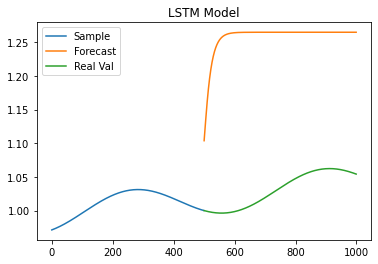

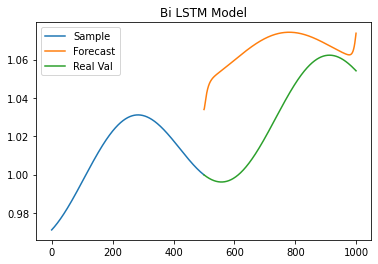

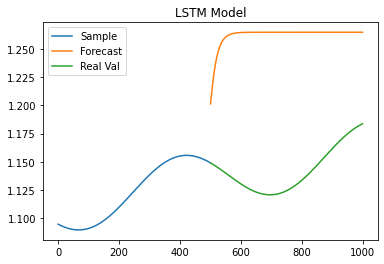

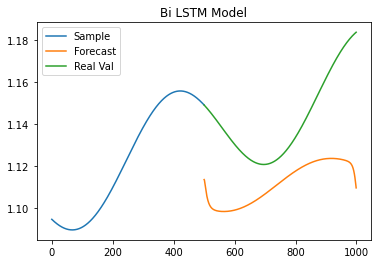

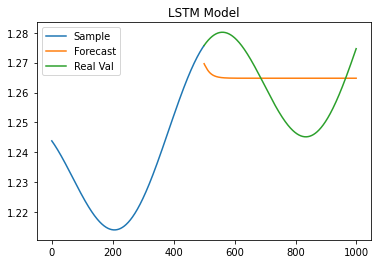

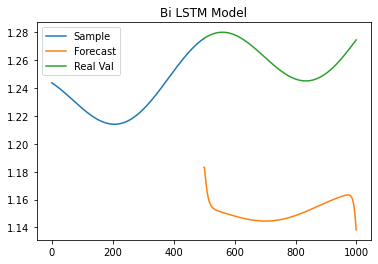

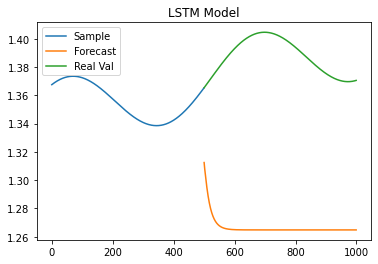

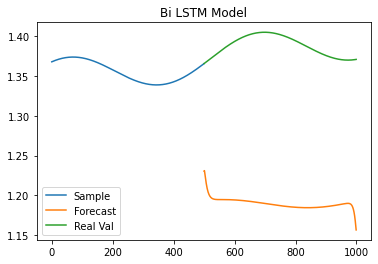

In [ ]:
n_time_steps = len(x_st_test[0])

for i in range(0, len(x_st_test), int(len(x_st_test)/4)):
  history = x_st_test[i]
  real_vals = x_st_test[i+(n_time_steps)]
  y_hat = gen_forecast(st_lstm_model, history)
  plot(history, real_vals, y_hat, 'LSTM Model')
  y_hat = gen_forecast(st_bi_lstm_model, history)
  plot(history, real_vals, y_hat, 'Bi LSTM Model')

##The conclusion here is that LSTMs can do a good job extracting seasonality for data that is seasonal in nature. Most stock price movements are not seasonal but cyclical in nature and this solution may not work in that case.
